In [1]:
from typing import Optional
from langgraph.graph import StateGraph, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from langchain.chat_models import init_chat_model
from langchain_mcp_adapters.client import MultiServerMCPClient
import asyncio
import os
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "RealWorld_MultiAIAgent_project"

In [3]:
llm = init_chat_model("groq:llama-3.1-8b-instant")

In [4]:
class AssistantState(MessagesState):
    next_agent: str
    intent: str

    normal_response: Optional[str]
    weather_info: Optional[str]
    calendar_status: Optional[str]
    colab_status: Optional[str]

    task_complete: bool = False


In [5]:
async def setup_mcp():
    client = MultiServerMCPClient(
        {
            "Weather": {
                "url": "http://127.0.0.1:8000/mcp",
                "transport": "streamable_http",
            },
            "Colab": {
                "url": "http://127.0.0.1:8001/mcp",
                "transport": "streamable_http",
            },
        }
    )

    tools = await client.get_tools()
    return tools


In [6]:
TOOLS = await setup_mcp()

In [7]:
TOOLS = {tool.name: tool for tool in TOOLS}

# Verify it worked
print(f"Connected tools: {list(TOOLS.keys())}")

Connected tools: ['get_weather', 'open_and_paste_colab']


In [8]:
def supervisor_agent(state: AssistantState):
    messages = state.get("messages", [])
    if not messages:
        return {"next_agent": "normal_agent"}
    
    text = messages[-1].content.lower()

    if any(word in text for word in ["colab", "notebook"]):
        return {"intent": "colab", "next_agent": "colab_agent"}
    elif "weather" in text:
        return {"intent": "weather", "next_agent": "weather_agent"}
    else:
        return {"intent": "normal", "next_agent": "normal_agent"}

In [9]:
def normal_agent(state: AssistantState):
    response = llm.invoke(state["messages"])

    return {
        "normal_response": response.content,
        "messages": [response],
        "task_complete": True,
        "next_agent": "end",
    }


In [10]:
async def weather_agent(state: AssistantState):
    # Get the last message content
    user_input = state["messages"][-1].content
    
    # Simple extraction: take the last word (e.g., "Delhi")
    city = user_input.strip("?.!").split()[-1]

    # Use the tool from our TOOLS dictionary
    if "get_weather" in TOOLS:
        # ainvoke expects a dict of arguments matching the tool's parameters
        weather_data = await TOOLS["get_weather"].ainvoke({"location": city})
    else:
        weather_data = f"Error: Tool 'get_weather' not found in {list(TOOLS.keys())}"

    return {
        "weather_info": weather_data,
        "messages": [AIMessage(content=f"🌤️ {weather_data}")],
        "task_complete": True,
        "next_agent": "end",
    }

In [11]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage
import re

async def colab_agent(state: AssistantState):
    user_query = state["messages"][-1].content
    
    code_prompt = f"""
    Write ONLY the raw python code for: {user_query}. 
    Rules:
    1. No markdown formatting (no ```).
    2. No explanations or comments outside the code.
    3. Just pure, executable Python.
    """
    
    code_response = llm.invoke([SystemMessage(content=code_prompt)])
    raw_content = code_response.content
    
    # --- IMPROVED RIGOROUS CLEANING ---
    # 1. Remove markdown code blocks (including the 'python' tag and trailing backticks)
    clean_code = re.sub(r'```(?:python)?\n?', '', raw_content) 
    clean_code = clean_code.replace('```', '')
    
    # 2. Remove bold headers (like **Fibonacci Series**)
    clean_code = re.sub(r'\*\*.*?\*\*', '', clean_code)
    
    # 3. Final strip to remove leading/trailing whitespace or empty lines
    clean_code = clean_code.strip()
    
    tool_name = "open_and_paste_colab" 
    
    if tool_name in TOOLS:
        # We pass the cleaned code to your perfected PyAutoGUI server
        result = await TOOLS[tool_name].ainvoke({"python_code": clean_code})
    else:
        result = f"Error: Tool '{tool_name}' not found."

    return {
        "colab_status": result,
        "messages": [AIMessage(content=f"Sent to Colab:\n{clean_code}")],
        "task_complete": True,
        "next_agent": "end",
    }

In [12]:
def router(state: AssistantState):
    if state.get("task_complete"):
        return END
    return state.get("next_agent", "supervisor")


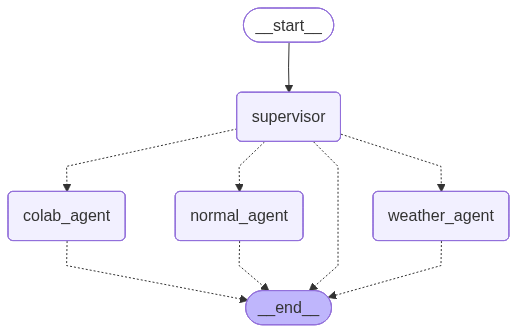

In [13]:
workflow = StateGraph(AssistantState)

workflow.add_node("supervisor", supervisor_agent)
workflow.add_node("normal_agent", normal_agent)
workflow.add_node("weather_agent", weather_agent)
workflow.add_node("colab_agent", colab_agent)

workflow.set_entry_point("supervisor")

routing_map = {
    "normal_agent": "normal_agent",
    "weather_agent": "weather_agent",
    "colab_agent": "colab_agent",
    END: END,
}

workflow.add_conditional_edges("supervisor", router, routing_map)
workflow.add_conditional_edges("normal_agent", router, {END: END})
workflow.add_conditional_edges("weather_agent", router, {END: END})
workflow.add_conditional_edges("colab_agent", router, {END: END})

final_workflow = workflow.compile()
final_workflow

In [15]:
result = final_workflow.invoke({
    "messages": [HumanMessage(content="Explain transformers in simple terms")]
})

print("=== NORMAL RESPONSE ===")
print(result["normal_response"])


=== NORMAL RESPONSE ===
**What are Transformers?**

Transformers are a type of artificial neural network (ANN) architecture designed specifically for processing sequential data, such as text, speech, and images. They were first introduced in a research paper in 2017 by Vaswani et al. and have since become a fundamental component of many natural language processing (NLP) and computer vision tasks.

**How do Transformers work?**

Transformers use self-attention mechanisms to understand the relationships between different parts of a sequence. Here's a simplified explanation:

1. **Input**: The transformer takes in a sequence of tokens, such as words or characters.
2. **Embeddings**: Each token is converted into a numerical vector (embedding) that captures its meaning and context.
3. **Self-Attention**: The transformer applies self-attention to each token, which allows it to understand the relationships between tokens at different positions in the sequence. This is done by computing a weig

In [16]:
result = await final_workflow.ainvoke({
    "messages": [HumanMessage(content="What is the weather in GUWAHATI?")]
})

print("=== WEATHER RESPONSE ===")
print(result["weather_info"][-1]["text"])


=== WEATHER RESPONSE ===
The current weather in Guwahati is 20.2°C with a wind speed of 6.4 km/h.


In [18]:
# 1. Define a query that triggers code generation
query = "Write end to end ML pipeline code and open in colab"

# 2. Run the workflow
result = await final_workflow.ainvoke({
    "messages": [HumanMessage(content=query)]
})

# 3. Print the results
print("\n=== GENERATED CODE ===")
print(result["messages"][-1].content)

print("\n=== TOOL EXECUTION STATUS ===")
colab_status = result.get("colab_status")

# Check if it's a list (standard MCP tool output) or a single string
if isinstance(colab_status, list) and len(colab_status) > 0:
    # Most MCP tools return a list of content blocks; we want the 'text' field
    print(colab_status[0].get("text", "No text found in tool output"))
else:
    print(colab_status if colab_status else "No status returned")


=== GENERATED CODE ===
Sent to Colab:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Load dataset
url = "https://raw.githubusercontent.com/mwaskom/seaborn-data/master/tips.csv"
df = pd.read_csv(url)

# Data Preprocessing
X = df[['total_bill', 'sex', 'smoker', 'day', 'time', 'size']]
y = df['tip']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA(n_components=2)
X_train_pca = pca.fit_tra